# Mini Reto 007 del grupo Python para Trading

## Backtrader - Estrategia de reversión a la media RSI 25/75 


Trás el Mini-Reto 006 continuamos con Backtrader, implementando una estrategia bien conocida que incrementa un poco su complejidad.

Se trata de la estrategia RSI 25/75 publicada por Larry Connors y Cesar Álvarez en su libro “High Probability ETF Trading: 7 Professional Strategies to Improve Your ETF Trading”. 

Utiliza el índice de fuerza relativa RSI para medir cuando un activo se encuentra sobrevendido durante una tendencia alcista o sobrecomprado durante una tendencia bajista. Sugieren bajar el período de tiempo para el indicador RSI de su nivel habitual de 14 a 4, para aumentar significativamente el número de operaciones, con un indicador más "nervioso".

El sistema utiliza una de media móvil simple, con un periodo de 200, para determinar la tendencia a largo plazo. 

En mercado con tendencia alcista, es decir precio de cierre por encima de la media de 200 días, se abre posición larga cuando el indicador RSI cae por debajo 25. Se cierra la posición cuando el RSI cruza por encima de 55. 

En mercado bajista, abre posición corta cuando el RSI cruza por encima 75 y cierra cuando el RSI cae por debajo 45.


Para hacerlo más cercano a la realidad debes incorporar una comisión de 0.0035 USD por acción.

Y como gestión de capital invertir el 90% del valor de la cartera en cada operación, mediante un sizer de Backtrader.



Partiendo del código que hay a continuación:

- 1) Diseñar la estrategia en base a los indicadores
- 2) Configurar el entorno de backtrader
- 3) Ejecutar el backtest con la estrategia
- 4) Optimizar los parámetros de periodos del RSI y SMA para maximizar el ratio de Sharpe.
- 5) Ejecutar el backtest con los parámetros obtenidos
- 6) Analizar los resultados con Pyfolio

In [1]:
# Importamos las librerías y configuramos la visualización
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf
import backtrader as bt
from math import floor

import matplotlib as plt
plt.rcParams['figure.figsize']=[12, 8]
%config InlineBackend.figure_format = 'retina'

#plt.rcParams['figure.figsize'] = [12, 8]
#%config InlineBackend.figure_format = 'retina'

In [2]:
# Descargamos los datos

#symbol = 'AAPL'
symbol = 'MTS.MC'
quotes = yf.download(symbol, start='2010-1-1', end='2020-11-25')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Clase heredada de bt.Sizer al que le pasamos el porcentaje
# que queremos estar expuestos


class PercentValue(bt.Sizer):
    params = (('percent', .90),)

    def _getsizing(self, comminfo, cash, data, isbuy):
        # Calculamos la posición diviendo el porcentaje deseado
        # del valor de la cartera entre el precio del activo
        return floor((self.broker.get_value() * self.params.percent / data) )

In [4]:
# Diseñamos la estrategia de revesión a la media con RSI


class cruceRSI_(bt.Strategy):
    params = dict(sma_period=200,
                  rsi_period=4)

    def __init__(self):
        self.sma = bt.ind.SMA(self.data.close, period=int(self.p.sma_period))
        #self.rsi = bt.ind.RSI(self.data.close, period=int(self.p.rsi_period)) # Da errores, no usar
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=self.p.rsi_period, safediv=True)
        self.rsi_25 = bt.ind.CrossOver(self.rsi, 25, plotname='RSI_25')
        self.rsi_45 = bt.ind.CrossOver(self.rsi, 45, plotname='RSI_45')
        self.rsi_55 = bt.ind.CrossOver(self.rsi, 55, plotname='RSI_55')
        self.rsi_75 = bt.ind.CrossOver(self.rsi, 75, plotname='RSI_75')
        self.order = None

    def notify_order(self,order):
        if order.status in [order.Completed]:
            if order.isbuy():
                self.order = "buy"
            elif order.issell():
                self.order = "sell"
            else:
                self.order = None
        
    def next(self):
        if self.position:                           # Si hay una operacion abierta
            if self.rsi_55 and self.order == 'buy': # Y rsi cruza por encima de 55
                self.close()                        # cerramos la posición, para después abrir si procede
            if self.rsi_45 == -1  and self.order == 'sell':    # Y rsi cruza por debajo de 45
                self.close()
        
        if self.data.close > self.sma and self.rsi_25 == -1:   # Tendencia Alcista y rsi cruza por debajo de 25
            self.buy()
        if not(self.position) and self.data.close < self.sma \
                              and self.rsi_75:      # Tendencia Bajista y rsi 75 cruza por encima de 75
            self.sell()

In [5]:
## Definimos los parametros de la estrategia

cash = 10000
exposure=.90
sma_period=200
rsi_period=4

## Configuramos el entorno

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=quotes)
cerebro.adddata(data)

cerebro.addstrategy(cruceRSI_, sma_period=sma_period, rsi_period=rsi_period) # Determinamos la estrategia
cerebro.addsizer(PercentValue, percent=exposure)  # Añadimos el sizer
cerebro.broker.setcommission(commission=0.0035)   # Añadimos las comisiones
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

## Ejecuta el backtesting

results = cerebro.run()

results[0].analyzers.sharpe.get_analysis()['sharperatio']

-0.4368757951357001

<IPython.core.display.Javascript object>


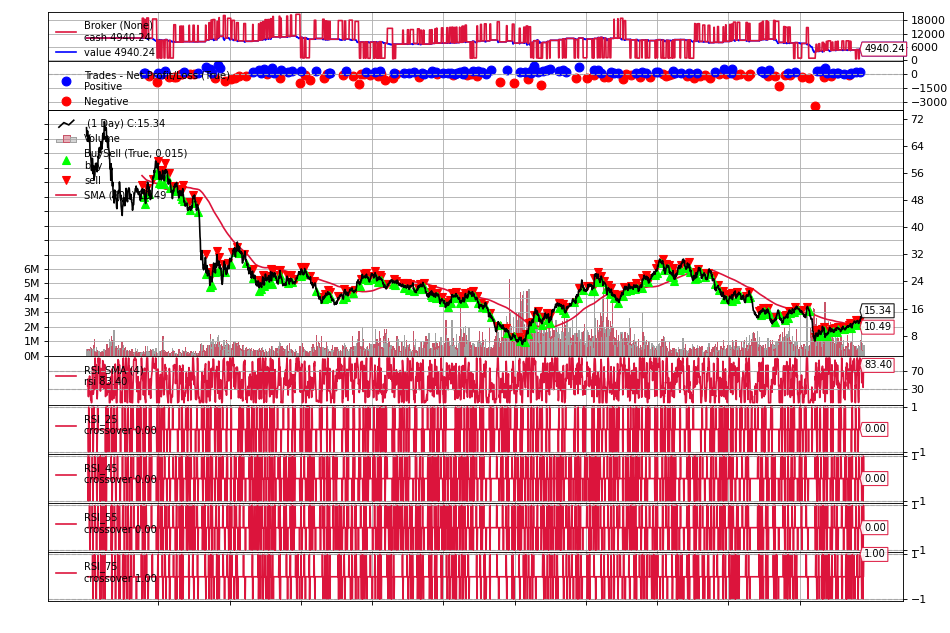

[[<Figure size 864x576 with 9 Axes>]]

In [6]:
# Grafica de la estrategia


cerebro.plot()

### A partir de aquí sigues solo. Toca optimizar y después analizar.

#### 4) Optimizar los parámetros de periodos del RSI y SMA para maximizar el ratio de Sharpe.

Separamos la muestra para optimizar con el 70% de los datos (in-sample) y operar la estrategia optimizada con el 30% restante (out-sample).

In [7]:
percent_split = 0.7
insample = quotes.iloc[:int(len(quotes)*percent_split)]
outsample = quotes.iloc[int(len(quotes)*percent_split):]

##### Opstrategy

Esta es la forma nativa de Backtrader para optimizar parámetros. En la siguiente sección, usaremos otra libreria de optimización para poder compararlas.

In [ ]:
## Definimos los parametros de la estrategia

cash = 10000
exposure = .90
sma_range = range(50, 300, 5)
rsi_range = range(2, 30, 2)

## Configuramos el entorno
cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=insample)
cerebro.adddata(data)

cerebro.optstrategy(cruceRSI_, sma_period=sma_range, rsi_period=rsi_range)
cerebro.addsizer(PercentValue, percent=exposure)  
cerebro.broker.setcommission(commission=0.0035, margin=True)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

## Ejecutamos el backtesting
results = cerebro.run()


In [ ]:
import pandas as pd

df = []
for result in results:
    df.append({ 'sma': result[0].params.sma_period,
                'rsi': result[0].params.rsi_period,
                'sharpe': result[0].analyzers.sharpe.get_analysis()['sharperatio']})
    
df = pd.DataFrame(df).set_index(['sma','rsi']).sort_values('sharpe',ascending=False)
df

In [ ]:
# sma y rsi del mejor sharpe
optstrategy_optimal_params = {'sma_period': df.iloc[0].name[0],
                              'rsi_period': df.iloc[0].name[1]}
optstrategy_optimal_params

Vemos la gráfica con estos parámetros para los datos **in-sample**

In [ ]:
## Configuramos el entorno
cash = 10000
exposure = .90

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=insample)
cerebro.adddata(data)

cerebro.addstrategy(cruceRSI_,  sma_period=optstrategy_optimal_params['sma_period'], 
                                rsi_period=optstrategy_optimal_params['rsi_period'])
cerebro.addsizer(PercentValue, percent=exposure)  
cerebro.broker.setcommission(commission=0.0035, margin=True)

cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

## Ejecutamos el backtesting
results = cerebro.run()

In [ ]:
# Grafica de la estrategia
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'

cerebro.plot()

##### Optunity

La diferencia crucial con este método, al menos con esta implementación, es que los parámetros los prueba con incrementos de a 1. Lo que, si bien permite probar todas las combinaciones, lo hace mucho mas lento, respecto a probar los parametros en un rango, saltando N valores, como se hizo anteriormente con `range()`

In [ ]:
import optunity
import optunity.metrics

cash = 10000
exposure = .90

def testStrategy(sma_period, rsi_period):
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(cash)

    data = bt.feeds.PandasData(dataname=insample)
    cerebro.adddata(data)

    cerebro.addstrategy(cruceRSI_, sma_period=int(sma_period), rsi_period=int(rsi_period))
    cerebro.addsizer(PercentValue, percent=exposure)
    cerebro.broker.setcommission(commission=0.0035, margin=True)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

    ## Ejecuta el backtesting

    results = cerebro.run()
    
    return results[0].analyzers.sharpe.get_analysis()['sharperatio']

opt = optunity.maximize(testStrategy, 
                        num_evals=100,
                        pmap=optunity.pmap, 
                        sma_period=[50, 250], 
                        rsi_period=[2, 20])

optunity_optimal_params, details, _= opt
print('Parámetros óptimos con Optunity:')
print('sma_period = %i' % int(optunity_optimal_params['sma_period']))
print('rsi_period = %i' % int(optunity_optimal_params['rsi_period']))

#### 5) Ejecutar el backtest con los parámetros obtenidos

Ahora vamos a probar los parámetros optimizados obtenidos, con el 30% de datos excluidos de la optimización (out-sample). De esta forma sabremos si la optimización ha funcionado bien en períodos futuros a la optimización de parámetros y sabremos como de bien/mal habría ido en "real".

##### Opstrategy

In [ ]:
# Grafica de la estrategia
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'

cash = 10000
exposure = .90
sma = int(optstrategy_optimal_params['sma_period'])
rsi = int(optstrategy_optimal_params['rsi_period'])

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=outsample)
cerebro.adddata(data)
cerebro.addstrategy(cruceRSI_,  sma_period=sma, 
                                rsi_period=rsi)
cerebro.addsizer(PercentValue, percent=exposure)
cerebro.broker.setcommission(commission=0.0035, margin=True)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

results = cerebro.run()
optstrategy_optimal_params['results'] = results

print(f'sma: {sma} | rsi: {rsi} | sharpe: %f'%results[0].analyzers.sharpe.get_analysis()['sharperatio'])
    
cerebro.plot()

##### Optunity

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = 'retina'

cash = 10000
exposure = .90
sma = int(optunity_optimal_params['sma_period'])
rsi = int(optunity_optimal_params['rsi_period'])

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=outsample)
cerebro.adddata(data)
cerebro.addstrategy(cruceRSI_,  sma_period=sma, 
                                rsi_period=rsi)
cerebro.addsizer(PercentValue, percent=exposure)
cerebro.broker.setcommission(commission=0.0035, margin=True)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

results = cerebro.run()
optunity_optimal_params['results'] = results

print(f'sma: {sma} | rsi: {rsi} | sharpe: %f'%results[0].analyzers.sharpe.get_analysis()['sharperatio'])
    
cerebro.plot()

#### 6) Analizar los resultados con Pyfolio

##### Opstrategy

In [ ]:
pyfolio_analyzer = optstrategy_optimal_params['results'][0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [ ]:
%matplotlib inline
pf.create_full_tear_sheet(returns, transactions=transactions, positions=positions)

##### Optunity

In [ ]:
pyfolio_analyzer = optunity_optimal_params['results'][0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [ ]:
%matplotlib inline
pf.create_full_tear_sheet(returns, transactions=transactions, positions=positions)